In [40]:
%matplotlib inline

### Compared to model2,  model3...
- `add conv512`
- `add avg(1,1)`
- `have only one FC layer remaining`
- `delete droupout`
- `initialize with kaiming normal`

In [41]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import copy

plt.ion()   # interactive mode

In [42]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
setup_seed(20)

In [43]:
# Data augmentation and normalization for training, just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, hue=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'eval': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/kaggle/input/caltech101/Caltech101/Caltech101'
batch_size = 64
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'eval', 'test']}
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'eval', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size//8, shuffle=True, num_workers=4) for x in ['eval', 'test']}
dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'eval', 'test']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [44]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2,self).__init__()
        
        self.conv1_112=nn.Sequential(
            nn.Conv2d(3,32,kernel_size=5,stride=1, padding=(2,2)),             
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2_56=nn.Sequential(
            nn.Conv2d(32,64,5,1,2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        
        self.conv3_28=nn.Sequential(
            nn.Conv2d(64,128,5,1,2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )   
        self.conv4_14=nn.Sequential(
            nn.Conv2d(128,256,3,1,1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv5_7=nn.Sequential(
            nn.Conv2d(256,256,3,1,1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.conv6_7=nn.Sequential(
            nn.Conv2d(256,128,3,1,1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.FC=nn.Sequential(
            nn.Linear(6272,1568),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(1568,392),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(392,101) 
        )
        
    def forward(self,x):
        x = self.conv1_112(x)
        x = self.conv2_56(x)
        x = self.conv3_28(x)
        x = self.conv4_14(x)
        x = self.conv5_7(x)
        x = self.conv6_7(x)
        x = x.view(x.size(0),-1)
        x = self.FC(x)

        return x

In [45]:
class ModifyNet2(nn.Module):
    def __init__(self, pretrained):
        super(ModifyNet2,self).__init__()
        
        self.conv1_112 = copy.deepcopy(pretrained.conv1_112)
        self.conv2_56 = copy.deepcopy(pretrained.conv2_56)
        self.conv3_28 = copy.deepcopy(pretrained.conv3_28)
        self.conv4_14 = copy.deepcopy(pretrained.conv4_14)
        
        self.conv5_7 = nn.Sequential(
            nn.Conv2d(256,512,3,1,1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        nn.init.kaiming_normal_(self.conv5_7[0].weight, mode='fan_out')
        nn.init.constant_(self.conv5_7[1].weight, 1)
        nn.init.constant_(self.conv5_7[1].bias, 0)
        
        self.conv6_3=nn.Sequential(
            nn.Conv2d(512,512,3,1,1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        nn.init.kaiming_normal_(self.conv6_3[0].weight, mode='fan_out')
        nn.init.constant_(self.conv6_3[1].weight, 1)
        nn.init.constant_(self.conv6_3[1].bias, 0)
        
        self.avg = nn.AdaptiveAvgPool2d(output_size=(1,1))
        
        self.FC = nn.Linear(512,101)
        nn.init.kaiming_normal_(self.FC.weight)
        
    def forward(self,x):
        x = self.conv1_112(x)
        x = self.conv2_56(x)
        x = self.conv3_28(x)
        x = self.conv4_14(x)
        x = self.conv5_7(x)
        x = self.conv6_3(x)
        x = self.avg(x)
        x = x.view(x.size(0),-1)
        x = self.FC(x)

        return x

In [46]:
# def train_model(model, criterion, optimizer, scheduler, num_epochs):
def train_model(model, criterion, optimizer, num_epochs):
    since = time.time()
    
    statistics = {'train':([],[]), 'eval':([],[])} # train:(loss,acc), test:(loss,acc)
#     lrs = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'eval']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            step_loss = []
            step_acc = []
                      
            for step,(inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                # forward，track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
#                         lrs.append((step, optimizer.param_groups[0]['lr']))
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                step_loss.append(loss.item())
                step_acc.append(float(torch.sum(preds == labels.data)) / preds.size(0))                     
                
                # statistics                
                if step%30==1:
                    statistics[phase][0].append(np.mean(step_loss))
                    statistics[phase][1].append(np.mean(step_acc))
                    step_loss = []
                    step_acc = []

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'eval' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best eval Acc: {:4f}'.format(best_acc))

    return model, statistics

In [47]:
pretrained = Net2()
pretrained.load_state_dict(torch.load('/kaggle/input/pretrainedmodel2/model2.pth'))
model3 = ModifyNet2(pretrained)
model3.to(device)
print(model3)
num_epochs = 100

criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model3.parameters(),lr=0.001,weight_decay=1e-5)
# step_lr_scheduler = lr_scheduler.StepLR(optimizer1, step_size=30, gamma=0.5) # Decay LR by a factor of 0.1 every 30 epochs
# num_steps = 95 * num_epochs
# cosine_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer1, T_max = num_steps) 

ModifyNet2(
  (conv1_112): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2_56): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3_28): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4_14): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [48]:
# model2, statistics, lrs = train_model(model2, criterion1, optimizer1, cosine_lr_scheduler, num_epochs=num_epochs)
model3, statistics = train_model(model3, criterion2, optimizer2, num_epochs=num_epochs)

Epoch 0/99
----------
train Loss: 3.3710 Acc: 0.2798
eval Loss: 2.5453 Acc: 0.4293

Epoch 1/99
----------
train Loss: 2.6552 Acc: 0.3854
eval Loss: 2.0911 Acc: 0.5049

Epoch 2/99
----------
train Loss: 2.3628 Acc: 0.4437
eval Loss: 2.3706 Acc: 0.4415

Epoch 3/99
----------
train Loss: 2.2000 Acc: 0.4721
eval Loss: 1.9059 Acc: 0.5280

Epoch 4/99
----------
train Loss: 2.0983 Acc: 0.4920
eval Loss: 1.7529 Acc: 0.5378

Epoch 5/99
----------
train Loss: 1.9866 Acc: 0.5169
eval Loss: 1.5350 Acc: 0.6037

Epoch 6/99
----------
train Loss: 1.9267 Acc: 0.5266
eval Loss: 1.5170 Acc: 0.6195

Epoch 7/99
----------
train Loss: 1.8653 Acc: 0.5377
eval Loss: 1.5816 Acc: 0.5976

Epoch 8/99
----------
train Loss: 1.7428 Acc: 0.5727
eval Loss: 1.5071 Acc: 0.6000

Epoch 9/99
----------
train Loss: 1.7409 Acc: 0.5646
eval Loss: 1.4102 Acc: 0.6244

Epoch 10/99
----------
train Loss: 1.6793 Acc: 0.5860
eval Loss: 1.3078 Acc: 0.6439

Epoch 11/99
----------
train Loss: 1.5981 Acc: 0.5975
eval Loss: 1.3675 Acc

eval Loss: 0.9850 Acc: 0.7720

Epoch 97/99
----------
train Loss: 0.5155 Acc: 0.8622
eval Loss: 0.9773 Acc: 0.7829

Epoch 98/99
----------
train Loss: 0.5074 Acc: 0.8552
eval Loss: 1.0290 Acc: 0.7805

Epoch 99/99
----------
train Loss: 0.4969 Acc: 0.8684
eval Loss: 1.0015 Acc: 0.7744

Training complete in 94m 49s
Best eval Acc: 0.793902


In [ ]:
# lr = np.array(lrs)[:,1]
# plt.plot(np.arange(len(lr)),lr)

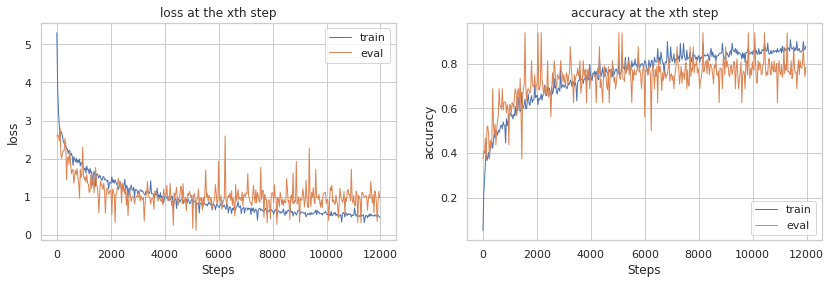

In [49]:
num_epochs=100
def visualize_accuracy(num_epochs, statistics):
    sns.set(style="whitegrid")
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
    for phase,(loss,acc) in statistics.items():
        loss_hist = [float(h) for h in loss]
        acc_hist = [float(h) for h in acc]
        ax1.plot(np.arange(len(loss_hist))*30, loss_hist, label = phase, linewidth = 1)
#         ax1.set(xlabel = 'Epochs', ylabel='loss',title='loss at the xth epoch');
        ax1.set(xlabel = 'Steps', ylabel='loss',title='loss at the xth step');
        ax1.legend();
        ax2.plot(np.arange(len(acc_hist))*30, acc_hist, label = phase, linewidth = 1)
#         ax2.set(xlabel = 'Epochs', ylabel='accuracy',title='accuracy at the xth epoch');
        ax2.set(xlabel = 'Steps', ylabel='accuracy',title='accuracy at the xth step');
        ax2.legend();
    fig.savefig('acc_loss_model3(2).png')
visualize_accuracy(num_epochs, statistics)

In [50]:
PATH = '/kaggle/working/model3(2).pth'
torch.save(model3.state_dict(), PATH)

In [51]:
from IPython.display import FileLink
FileLink('model3(2).pth')

/kaggle/working/model3_2.pth